- with classification
    - classification으로 1,0 구분하는거랑 regression 둘다 만들어두고,
    - classification=1인 경우에 regression 결과값, classification=0인 경우에 0 넣는 방법

# Library Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

from base import gc_collect_all, setdiff
from filesystem_utils import mkdir
from graph import abline
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [2]:
gc_collect_all()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
def return_unique_columns(data):
    unique_info = data.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    return unique_cols

In [5]:
class CFG:
    SEED = 42
    N_SPLITS = 5
    TARGET = 'price(원/kg)'
    KEY_FEATURES = ['item','corporation','location']
    TARGET_TRANSFORMATION = 'identity'
    SUBSET_DEPTH = 3

<br></br>

# Data

## Data Load

In [6]:
# item:
#     TG : 감귤
#     BC : 브로콜리
#     RD : 무
#     CR : 당근
#     CB : 양배추

In [7]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
trade_df = pd.read_csv('./data/international_trade.csv')

In [8]:
print(train_df.shape)
train_df.head()

(59397, 7)


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [9]:
print(test_df.shape)
test_df.head()

(1092, 5)


,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [10]:
print(trade_df.shape)
trade_df.head()

(1274, 7)


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


<br>

## Preprocessing

In [11]:
def add_week(weekend):
    week = 1
    week_list = []
    for weekend in weekend:
        if weekend==1:
            week+=1
        week_list.append(week)
    return week_list

In [12]:
def preprocessing(data):
    d = data.copy()
    
    d = d.sort_values(CFG.KEY_FEATURES).reset_index(drop=True)
    
    # (1) datetime format
    d['timestamp'] = d['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
    
    # (2) delete unuse features
    unuse_features = ['ID'] #'supply(kg)'
    unuse_features = list(set(d.columns)&set(unuse_features))
    d.drop(unuse_features,axis=1,inplace=True)

    return d

In [13]:
def merge_trade_data(data,trade_data):
    d, td = data.copy(), trade_data.copy()
    
    ### trade data preprocessing
    
    # # (1) 흑자여부
    td.drop('무역수지',axis=1,inplace=True)

    # (2) 품목명 수정 및 필요없는 품목 정보 제거
    replace_dict = {
        '감귤': 'TG',
        '꽃양배추와 브로콜리(broccoli)': 'BC',
        '당근': 'CR',
        '순무': 'RD',
        '양배추': 'CB',
    }
    td['품목명'] = td['품목명'].map(replace_dict)
    td.dropna(subset=['품목명'], inplace=True)
    
    ### merge data
    d['기간'] = [str(t)[:7] for t in d['timestamp']]
    merged = pd.merge(d,td.rename(columns={'품목명':'item'}),how='left',on=['기간','item'])
    merged.drop('기간',axis=1,inplace=True)
    
    # # 2023년 3월 데이터는 trade 데이터에 없으므로 가장 최근의 값으로 채워줌
    # merged.ffill(inplace=True)
    
    return merged

In [14]:
def feature_engineering(data):
    d = data.copy()
    
    # (1) date columns
    d['year']       = d.timestamp.dt.year
    d['month']      = d.timestamp.dt.month
    d['day']        = d.timestamp.dt.day
    d['weekday']    = d.timestamp.dt.weekday
    d['weekend']    = d.timestamp.dt.weekday.isin([5,6]).astype(int)
    d['week']       = add_week(d['weekend'])

    # (2) is holiday & is dayoff
    holiday_list = get_holiday(d['year'].unique())
    d['is_holiday'] = d.timestamp.isin(holiday_list).astype(int)
    d['is_dayoff']  = ((d.is_holiday==1) | (d.weekend==1)).astype(int)
    
    # # (3) 무역수지, 흑자여부 추가
    # d['무역수지'] = d['수출 금액'] - d['수입 금액']
    # d['흑자여부'] = np.where(d['무역수지']>0,1,0)
    
    return d

In [15]:
# from copy import deepcopy
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer, IterativeImputer

# def imputation(train_data,test_data,method):
#     if method in ['mean','median']:
#         base_imputer = SimpleImputer(missing_values=np.nan, strategy=method)
#     elif method=='mice':
#         base_imputer = IterativeImputer(random_state=CFG.SEED)
#     else:
#         raise ValueError(f"Unknown method={method}")
    
#     numerical_cols = train_data.select_dtypes(include=[int,float]).columns.tolist()
#     numerical_cols = list(set(numerical_cols)-set([CFG.TARGET]))
    
#     train_list = []
#     test_list = []
#     for (item,corporation,location),tr in tqdm(train_data.groupby(['item','corporation','location'])):
#         te = test_data[(test_data['item']==item) & (test_data['corporation']==corporation) & (test_data['location']==location)]
#         imputer = deepcopy(base_imputer)
#         tr[numerical_cols] = imputer.fit_transform(tr[numerical_cols])
#         train_list.append(tr)
#         if len(te)>0:
#             te[numerical_cols] = imputer.transform(te[numerical_cols])
#             test_list.append(te)
        
#     new_train = pd.concat(train_list,axis=0)
#     new_test = pd.concat(test_list,axis=0)
    
#     return new_train.sort_index(), new_test.sort_index()

In [16]:
train_df = preprocessing(train_df)
# train_df = merge_trade_data(train_df, trade_df)
train_df = feature_engineering(train_df)

test_df = preprocessing(test_df)
# test_df = merge_trade_data(test_df, trade_df)
test_df = feature_engineering(test_df)

In [17]:
train_df.head()

,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,weekday,weekend,week,is_holiday,is_dayoff
0,2019-01-01,BC,A,J,0.0,0.0,2019,1,1,1,0,1,1,1
1,2019-01-02,BC,A,J,0.0,0.0,2019,1,2,2,0,1,0,0
2,2019-01-03,BC,A,J,7616.0,2559.0,2019,1,3,3,0,1,0,0
3,2019-01-04,BC,A,J,7488.0,2425.0,2019,1,4,4,0,1,0,0
4,2019-01-05,BC,A,J,10408.0,2097.0,2019,1,5,5,1,2,0,1


<br>

## Target Transformation

In [18]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION, offset=1)
train_df[CFG.TARGET] = target_transform.fit_transform(
    target=np.array(train_df[CFG.TARGET]).reshape(-1,1),
)

In [19]:
train_df.head()

,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,weekday,weekend,week,is_holiday,is_dayoff
0,2019-01-01,BC,A,J,0.0,0.000000,2019,1,1,1,0,1,1,1
1,2019-01-02,BC,A,J,0.0,0.000000,2019,1,2,2,0,1,0,0
2,2019-01-03,BC,A,J,7616.0,7.847763,2019,1,3,3,0,1,0,0
3,2019-01-04,BC,A,J,7488.0,7.793999,2019,1,4,4,0,1,0,0
4,2019-01-05,BC,A,J,10408.0,7.648740,2019,1,5,5,1,2,0,1


<br>

## Quantile values of Target

In [20]:
# feature engineering
calculator = CategoricalQuantileCalculator()
calculator.fit(
    data=train_df,
    test_data=test_df,
    target_feature=CFG.TARGET,
    cat_features=CFG.KEY_FEATURES,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df = calculator.transform(train_df)
test_df  = calculator.transform(test_df)

> Get quantiles of target by categorical features (depth=3)


Subset: item + corporation + location: 100%|██████| 7/7 [00:00<00:00, 20.87it/s]


<br>

## Group Scaler

In [21]:
# num_features = list(set(train_df.columns)-set(CFG.KEY_FEATURES+['timestamp',CFG.TARGET]))

In [22]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = GroupScaler(scaler=MinMaxScaler())
# scaler.fit(
#     data=train_df,
#     group=CFG.KEY_FEATURES,
#     num_features=num_features,
# )
# train_df = scaler.transform(train_df)
# test_df  = scaler.transform(test_df)

<br>

## Memory Reduce

In [23]:
train_df, _ = reduce_mem_usage(train_df,verbose=False)
test_df , _ = reduce_mem_usage(test_df ,verbose=False)

<br></br>

# EDA

In [24]:
# (1) key별 건수
train_df.groupby(CFG.KEY_FEATURES).size().head()

item  corporation  location
BC    A            J           1523
                   S           1523
      B            J           1523
                   S           1523
      C            J           1523
dtype: int64

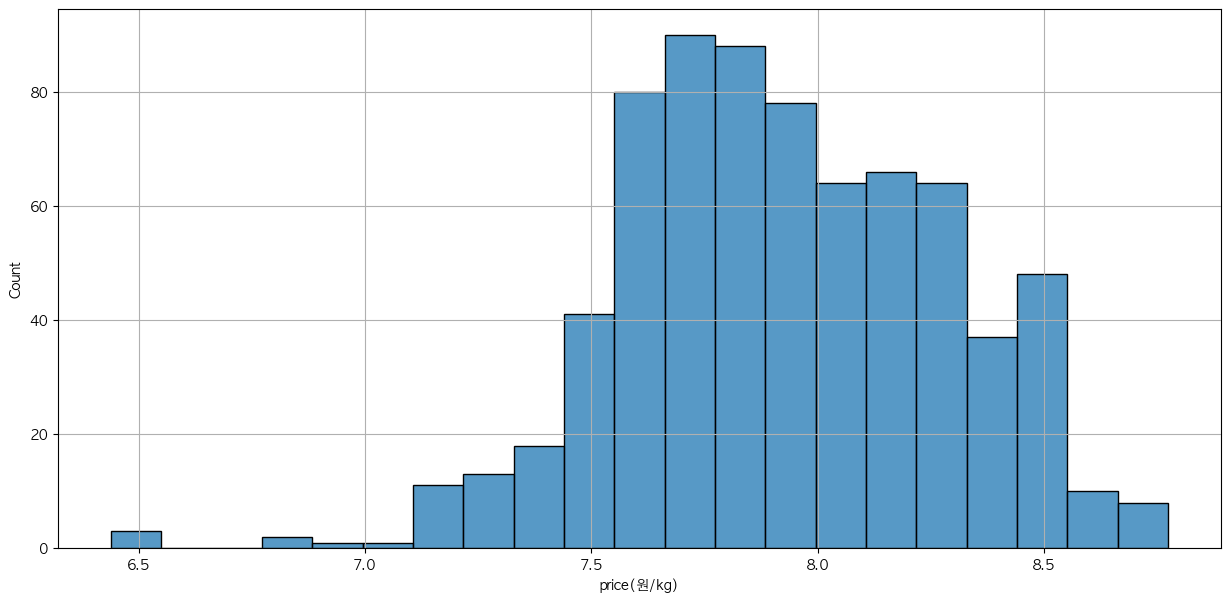

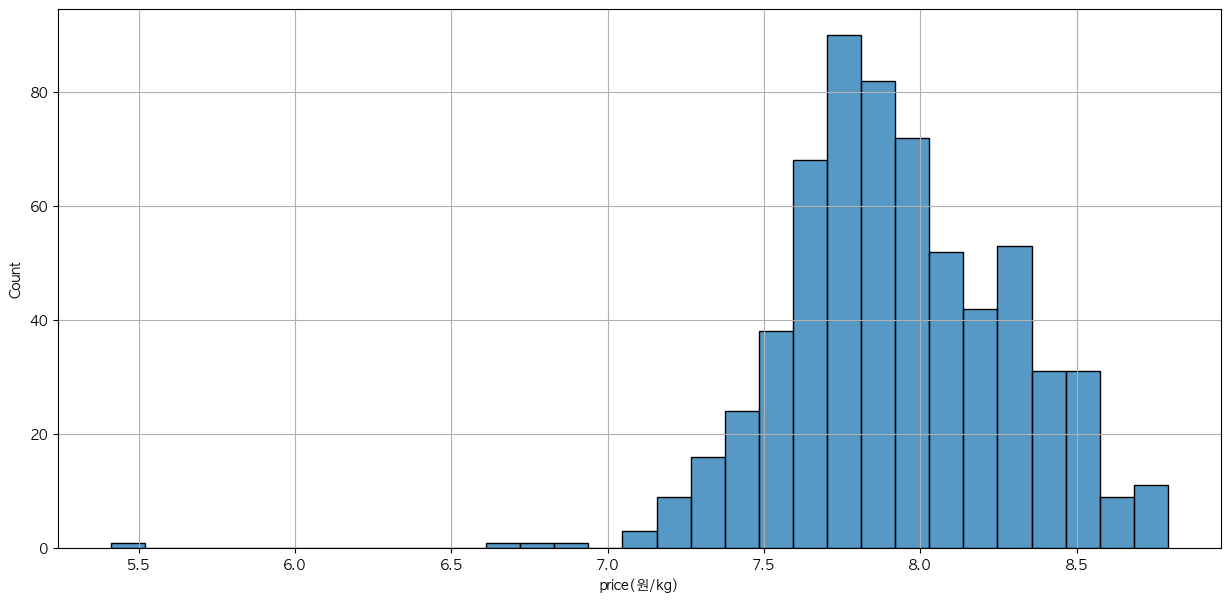

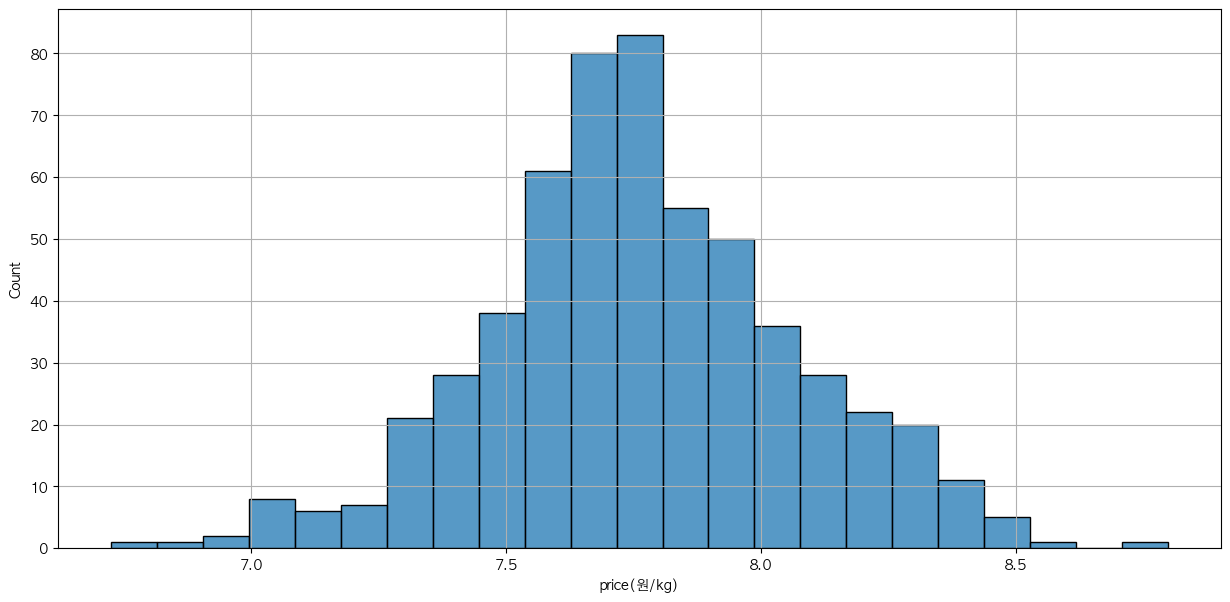

In [25]:
# (2) 품목/법인/지역에 따른 가격 히스토그램
# train_df.groupby(CFG.KEY_FEATURES)[CFG.TARGET].agg(Min=np.min,Max=np.max)
for i,(idx,d) in enumerate(train_df.groupby(CFG.KEY_FEATURES)):
    if i<3:
        target = d[CFG.TARGET]
        target = target[target!=0]
        
        plt.figure(figsize=(15,7))
        sns.histplot(target)
        plt.grid()
        plt.show()

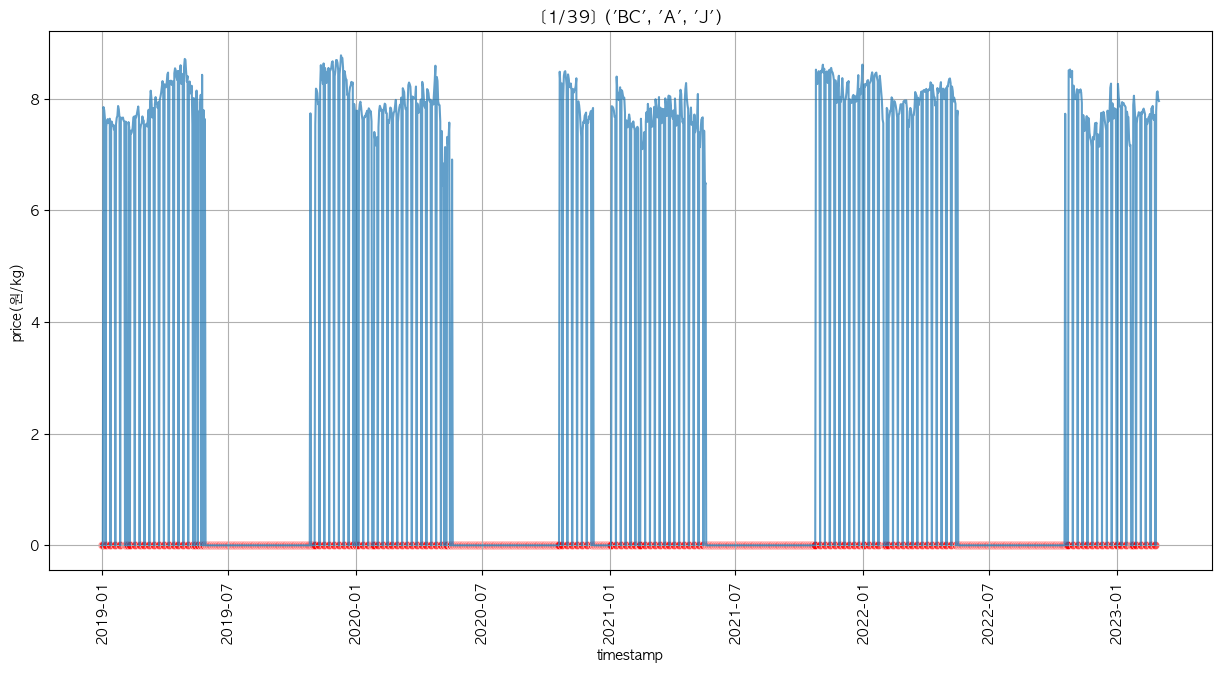

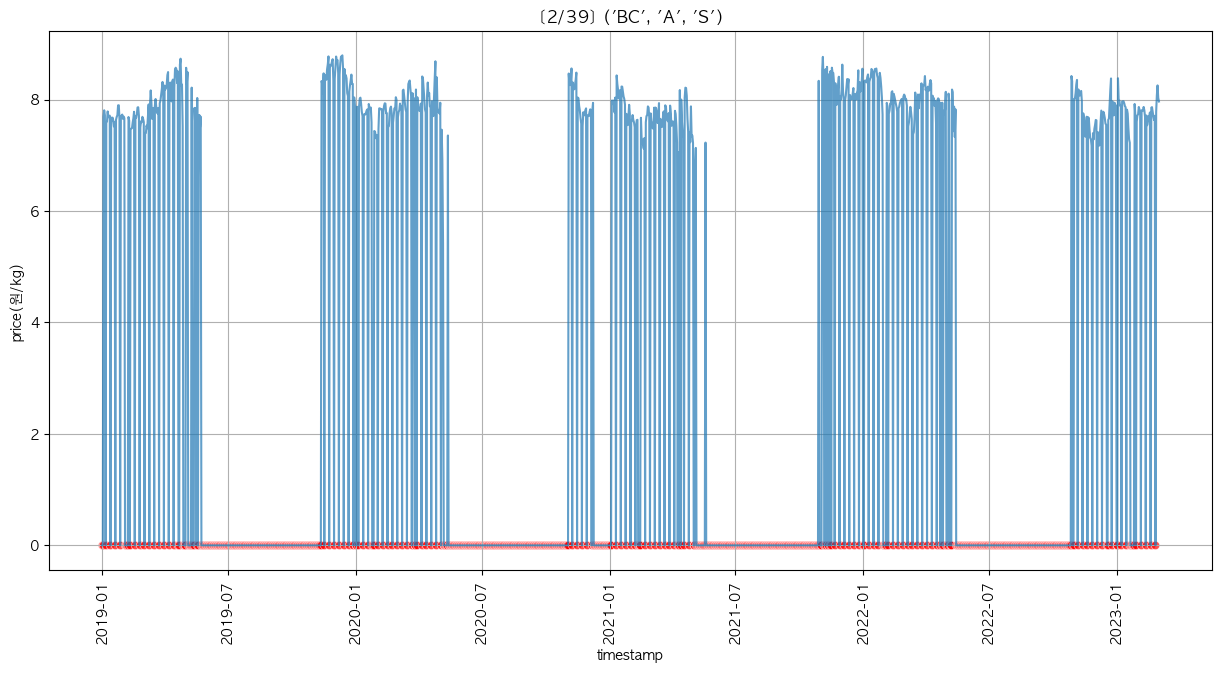

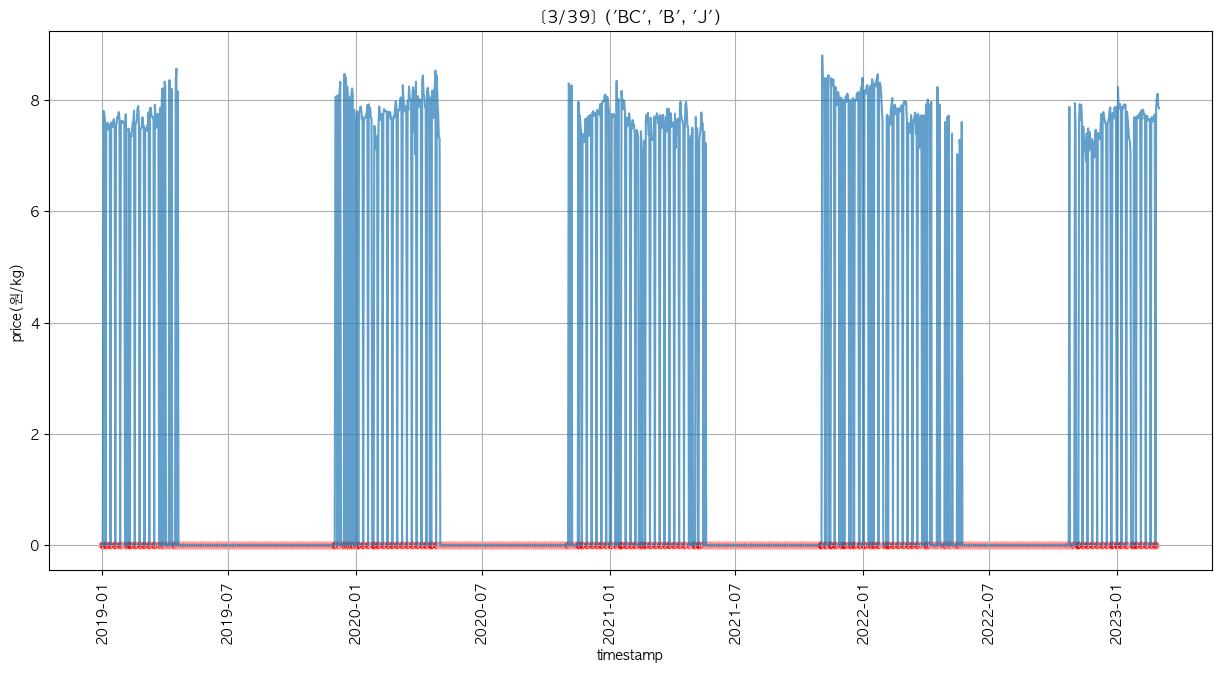

In [26]:
# (3) 품목/법인/지역에 따른 일별 가격변동
grp_data = train_df.groupby(CFG.KEY_FEATURES)
for i,(idx,d) in enumerate(grp_data):
    if i<3:
        plt.figure(figsize=(15,7))
        sns.lineplot(x=d['timestamp'],y=d[CFG.TARGET],alpha=0.7)
        if np.where(d[CFG.TARGET]==0,1,0).sum()>0:
            x=d['timestamp'][d[CFG.TARGET]==0]
            y=d[CFG.TARGET] [d[CFG.TARGET]==0]
            sns.scatterplot(x=x,y=y,color='red',alpha=0.7)
        plt.xticks(rotation=90)
        plt.grid()
        plt.title(f'[{i+1}/{len(grp_data)}] {idx}')
        plt.show()

<br></br>

# Modeling

In [27]:
from sklearn.model_selection import KFold
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.core.metrics import make_scorer

/Users/khj/anaconda3/envs/torch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
train_df.head()

,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,weekday,weekend,week,is_holiday,is_dayoff,item_Avg,item_Q25,item_Q50,item_Q75,corporation_Avg,corporation_Q25,corporation_Q50,corporation_Q75,location_Avg,location_Q25,location_Q50,location_Q75,item&corporation_Avg,item&corporation_Q25,item&corporation_Q50,item&corporation_Q75,item&location_Avg,item&location_Q25,item&location_Q50,item&location_Q75,corporation&location_Avg,corporation&location_Q25,corporation&location_Q50,corporation&location_Q75,item&corporation&location_Avg,item&corporation&location_Q25,item&corporation&location_Q50,item&corporation&location_Q75
0,2019-01-01,BC,A,J,0.0,0.000000,2019,1,1,1,0,1,1,1,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156
1,2019-01-02,BC,A,J,0.0,0.000000,2019,1,2,2,0,1,0,0,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156
2,2019-01-03,BC,A,J,7616.0,7.847763,2019,1,3,3,0,1,0,0,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156
3,2019-01-04,BC,A,J,7488.0,7.793999,2019,1,4,4,0,1,0,0,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156
4,2019-01-05,BC,A,J,10408.0,7.648740,2019,1,5,5,1,2,0,1,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156


In [29]:
train_data = train_df.copy()#[['timestamp','item','corporation','location','price(원/kg)']]
test_data  = test_df .copy()#[['timestamp','item','corporation','location']]

# train_data[CFG.KEY_FEATURES] = train_data[CFG.KEY_FEATURES].astype('category')
# test_data[CFG.KEY_FEATURES]  = test_data [CFG.KEY_FEATURES].astype('category')

train_data['item_id'] = [''.join(x) for x in train_data[CFG.KEY_FEATURES].values]
test_data ['item_id'] = [''.join(x) for x in test_data [CFG.KEY_FEATURES].values]

train_data.drop(CFG.KEY_FEATURES,axis=1,inplace=True)
test_data .drop(CFG.KEY_FEATURES,axis=1,inplace=True)

train_dataset = TimeSeriesDataFrame(train_data)
test_dataset  = TimeSeriesDataFrame(test_data)

In [30]:
train_data.head()

,timestamp,supply(kg),price(원/kg),year,month,day,weekday,weekend,week,is_holiday,is_dayoff,item_Avg,item_Q25,item_Q50,item_Q75,corporation_Avg,corporation_Q25,corporation_Q50,corporation_Q75,location_Avg,location_Q25,location_Q50,location_Q75,item&corporation_Avg,item&corporation_Q25,item&corporation_Q50,item&corporation_Q75,item&location_Avg,item&location_Q25,item&location_Q50,item&location_Q75,corporation&location_Avg,corporation&location_Q25,corporation&location_Q50,corporation&location_Q75,item&corporation&location_Avg,item&corporation&location_Q25,item&corporation&location_Q50,item&corporation&location_Q75,item_id
0,2019-01-01,0.0,0.000000,2019,1,1,1,0,1,1,1,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156,BCAJ
1,2019-01-02,0.0,0.000000,2019,1,2,2,0,1,0,0,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156,BCAJ
2,2019-01-03,7616.0,7.847763,2019,1,3,3,0,1,0,0,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156,BCAJ
3,2019-01-04,7488.0,7.793999,2019,1,4,4,0,1,0,0,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156,BCAJ
4,2019-01-05,10408.0,7.648740,2019,1,5,5,1,2,0,1,2.593496,0.0,0.0,7.617514,3.181964,0,0,7.446002,3.15618,0,0,7.204149,3.533878,0.0,0.0,7.84375,3.328869,0.0,0.0,7.734777,3.23921,0,0,7.252053,3.762155,0.0,0.0,7.88156,BCAJ


In [31]:
%%time

!rm -rf AutogluonModels
model = TimeSeriesPredictor(
    prediction_length=28,
    target=CFG.TARGET,
    eval_metric="RMSE",
    verbosity=0,
)
model.fit(
    train_dataset,
    random_seed=CFG.SEED,
    num_val_windows=5,
)
model.refit_full()

Global seed set to 42
	
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.


CPU times: user 50.6 s, sys: 15.7 s, total: 1min 6s
Wall time: 3min 23s


{'Naive': 'Naive_FULL',
 'SeasonalNaive': 'SeasonalNaive_FULL',
 'Theta': 'Theta_FULL',
 'AutoETS': 'AutoETS_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

In [84]:
pred = model.predict(train_dataset,random_seed=CFG.SEED).reset_index()
for col in pred.columns:
    if col not in ['item_id','timestamp']:
        pred[col] = target_transform.inverse_transform(pred[col])

weight = [(x+1)/10 if x<5 else (9-x)/10 for x in range(9) if 2<x+1<8]
weight = np.array(weight) / sum(weight)
answer = pred[[str((x+1)/10) for x in range(9) if 2<x+1<8]] @ weight

pred['ID'] = [f"{item_id[:2]}_{item_id[2:3]}_{item_id[3:4]}_{str(timestamp)[:10].replace('-','')}"
              for item_id,timestamp in pred[['item_id','timestamp']].values]
pred['answer'] = answer
# pred['answer'] = (answer + pred['mean']) / 2
pred['answer'] = [0.0 if p<0.0 else p for p in pred['answer']]

Global seed set to 42


In [85]:
# (mean) 727.77994
# (0.5,mean) 720.4180923696
# (weighted sum - **1) 720.1114586369
# (0.5, weighted sum)
# (weighted sum - **3, log) 1051.0657692954
# 882.4960808556
submit = pd.read_csv('./data/sample_submission.csv')[['ID']]
submit = pd.merge(submit,pred[['ID','answer']],how='left',on='ID')
submit.to_csv('./out/submit_autogluon_8.csv',index=False)
submit.head()

,ID,answer
0,TG_A_J_20230304,2717.626422
1,TG_A_J_20230305,2.573598
2,TG_A_J_20230306,3176.443881
3,TG_A_J_20230307,3931.585403
4,TG_A_J_20230308,3571.125788


In [ ]:
# kf = KFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)
# models = []
# k=0
# for tr_idx,val_idx in tqdm(kf.split(train_data),total=CFG.N_SPLITS):
#     k+=1
#     print('='*80)
#     print('> KFold: {}/{}'.format(k,CFG.N_SPLITS))
#     print('='*80)
#     tr_data, val_data = train_data.iloc[tr_idx], train_data.iloc[val_idx]
    
#     tr_data  = TabularDataset(tr_data)
#     val_data = TabularDataset(val_data)

#     model = TabularPredictor(label=CFG.TARGET, eval_metric='rmse')
#     model.fit(tr_data, val_data)
#     models.append(model)
#     # num_bag_folds = 10, num_bag_sets = 10, num_stack_levels = 0, presets='best_quality', time_limit=360000